# PV Temperature Model Validation
<li><b>1. Import data from DuraMAT</b></li>
https://datahub.duramat.org/dataset/293db0cb-e838-4f7a-8e77-f62e85328c47/resource/b54bdc36-1864-48a9-abab-daf0e3f8dcf5/download/pvpmc_2021_blind_modeling_comparison_data_s1-s6.xlsx
<li><b>2. Define relevant system & meteo data</b></li>
<li><b>3. Run model to be validated or import model results</b></li>
<li><b>4. Compare model to measured results and other baseline models</b></li>

In [168]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import pvlib
import pvanalytics
import sklearn.metrics
import scipy
from matplotlib.lines import Line2D 
from tabulate import tabulate

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['font.size']=12
plt.rcParams['lines.linewidth']=1.25
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['axes.titlesize']=12

## 1. Import data

In [192]:
df = pd.read_excel('pvpmc_2021_blind_modeling_comparison_data_s1-s6.xlsx', sheet_name='S2')
#df = pd.read_excel(https://datahub.duramat.org/dataset/293db0cb-e838-4f7a-8e77-f62e85328c47/resource/b54bdc36-1864-48a9-abab-daf0e3f8dcf5/download/pvpmc_2021_blind_modeling_comparison_data_s1-s6.xlsx,
#                   sheet_name='S2'

#Reassigning the index so the timesteps are at the middle of the hour
df.index = pd.date_range(start='2021-01-01 00:30:00', end='2021-12-31 23:30:00', freq='H')
df.index = df.index.tz_localize('MST')

df = df.where((df['bsrn_pass'] == 1) & (df['SNL No Snow'] == 1)).dropna()
df.replace(0, np.nan, inplace=True)
df.dropna(inplace=True)

df.head()

,Scenario,Year,Month,Day,Hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Ambient Temp (°C),Relative Humidity (%),Wind Speed (m/s),Measured front POA irradiance (W/m2),Measured module temperature (°C),Measured DC power (W),bsrn_pass,SNL No Snow
2021-01-01 08:30:00-07:00,S2,2020.0,1.0,1.0,9.0,185.738601,754.498236,31.546335,-3.652383,54.784333,1.803700,442.132104,6.645174,1292.814741,1.0,1.0
2021-01-01 09:30:00-07:00,S2,2020.0,1.0,1.0,10.0,353.666975,914.471581,40.138926,-0.708700,41.447333,2.923567,701.031595,17.712519,2276.603041,1.0,1.0
2021-01-01 10:30:00-07:00,S2,2020.0,1.0,1.0,11.0,482.624408,978.551782,44.586906,0.819633,38.089500,2.962067,879.164182,25.669461,2782.780150,1.0,1.0
2021-01-01 11:30:00-07:00,S2,2020.0,1.0,1.0,12.0,555.822941,1006.709614,44.024464,2.140700,36.223167,1.919817,977.788429,35.226433,2989.486270,1.0,1.0
2021-01-01 12:30:00-07:00,S2,2020.0,1.0,1.0,13.0,546.147743,865.317214,98.340036,3.236667,35.082167,1.641850,922.354253,38.056121,2796.495393,1.0,1.0


## 2. Define system and meteo data

In [193]:
#Defining constants and values that are consistent across all calculations
#Defining system constants 
module = {'Tilt': 35,'Latitude': 35.05,'Longitude': -106.54,'Altitude': 1600,'Surface Azimuth': 180,'String Length':12, 'iam0':1,'iam10': 0.9989, 'iam20': 1.0014, 'iam30': 1.0002, 'iam40':0.9984, 
          'iam45': 0.9941, 'iam50': 0.9911, 'iam55': 0.9815, 'iam60':0.9631, 'iam65':0.9352, 'iam70':0.8922, 'iam75':0.8134, 'iam80':0.6778, 'iam85': 0.4351, 
          'U0': 28.825, 'U1': 4.452, 'NOCT': 45, 'Unit Mass': 11.119}
#Running solar position calculations
#Calculate Solar Positions & Extraterrestrial DNI

spdf = pvlib.solarposition.get_solarposition(time=df.index, latitude=module['Latitude'], 
        longitude=module['Longitude'],temperature=df['Ambient Temp (°C) '], altitude=module['Altitude'])
spdf['dni_extra'] = pvlib.irradiance.get_extra_radiation(datetime_or_doy=df.index)
pres = pvlib.atmosphere.alt2pres(module['Altitude'])

#Save these values into the df with inputs & results for use in later analysis
df['Azimuth'] = spdf['azimuth']
df['Zenith'] = spdf['apparent_zenith']
df['Sol Elev'] = spdf['elevation']
df['Clearness Index'] = pvlib.irradiance.clearness_index(ghi=df['GHI (W/m2)'], solar_zenith=spdf['apparent_zenith'], extra_radiation = spdf['dni_extra'])
spdf.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time,dni_extra
2021-01-01 08:30:00-07:00,77.884310,77.950122,12.115690,12.049878,129.546848,-3.734135,1413.981805
2021-01-01 09:30:00-07:00,69.241432,69.279260,20.758568,20.720740,140.756151,-3.753597,1413.981805
2021-01-01 10:30:00-07:00,62.615700,62.643406,27.384300,27.356594,154.026282,-3.773049,1413.981805
2021-01-01 11:30:00-07:00,58.731118,58.754688,31.268882,31.245312,169.230769,-3.792492,1413.981805
2021-01-01 12:30:00-07:00,58.153100,58.176057,31.846900,31.823943,185.427677,-3.811925,1413.981805


In [194]:
#Calculate Environmental Conditions

edf = pvlib.irradiance.get_total_irradiance(surface_tilt=module['Tilt'], surface_azimuth=module['Surface Azimuth'], 
        solar_zenith=spdf['apparent_zenith'], solar_azimuth=spdf['azimuth'],dni=df['DNI (W/m2)'],
        ghi=df['GHI (W/m2)'], dhi=df['DHI (W/m2)'], dni_extra=spdf['dni_extra'], model ='perez', model_perez='albuquerque1988')
edf['aoi'] = pvlib.irradiance.aoi(surface_tilt=module['Tilt'], surface_azimuth=module['Surface Azimuth'], 
        solar_zenith=spdf['apparent_zenith'], solar_azimuth=spdf['azimuth'])
edf['airmass'] = pvlib.atmosphere.get_relative_airmass(zenith=spdf['apparent_zenith'])
edf['am_abs'] = pvlib.atmosphere.get_absolute_airmass(airmass_relative=edf['airmass'], pressure=pres)
df['AOI'] = edf['aoi']

#Calculate Effective Irradiance

ref_thetas= [0,10,20,30,40,45,50,55,60,65,70,75,80,85]
ref_iams = [module['iam0'],module['iam10'],module['iam20'],module['iam30'],module['iam40'],module['iam45'],module['iam50'],
            module['iam55'],module['iam60'],module['iam65'],module['iam70'],module['iam75'],module['iam80'],module['iam85']]
F2 = pvlib.iam.interp(aoi=edf['aoi'],theta_ref=ref_thetas,iam_ref=ref_iams )
df['Effective Irradiance'] = (edf['poa_direct'] * F2 + edf['poa_diffuse'])
df['IAMs'] = F2

## 3. Run the model or import the results to be validated

In [195]:
#Either run a model in this notebook or import the results into the column name below
model_name = 'Faiman'

#NOTE: if the model used calculates cell temperature it will need to be converted to module temperature for a fair comparison
# can use pvlib.temperature.sapm_cell_from_module

#run model here
df['Modeled Temp'] = pvlib.temperature.faiman(poa_global=df['Measured front POA irradiance (W/m2)'], temp_air=df['Ambient Temp (°C) '], wind_speed=df['Wind Speed (m/s)'],
                           u0=module['U0'], u1=module['U1'])

# or import model results here. Make sure timestamps line up and are middle-of-hour
# df['Modeled Temp'] = pd.read_excel('results.xlsx')

### Visualize the results of the model over a sample day 
This preliminary check helps make sure the results are feasible and there aren't any obvious extreme errors

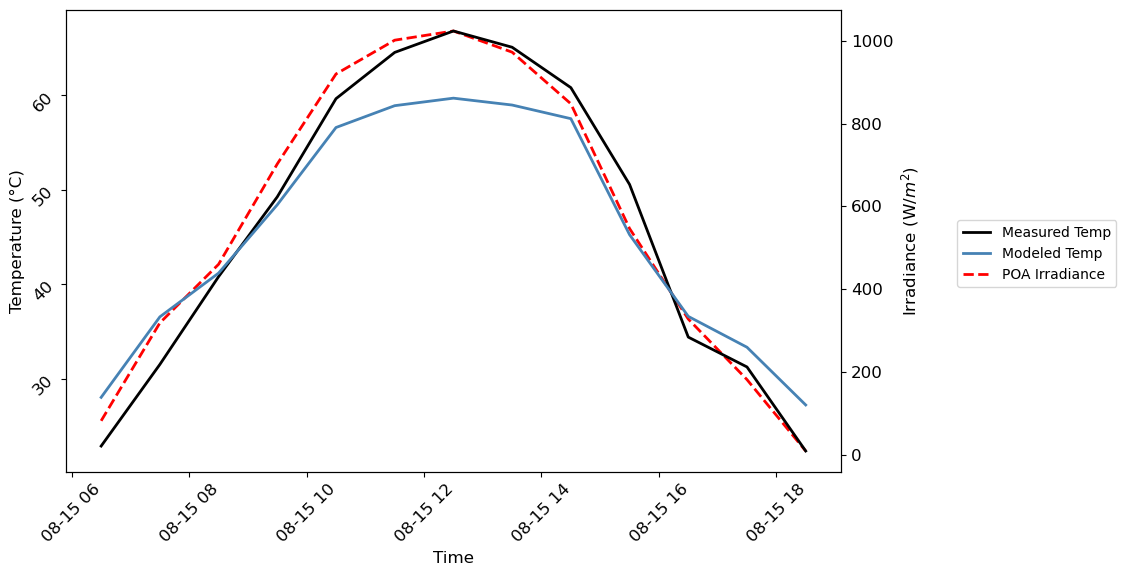

In [196]:
#diurnal plot
day = 15
month = 8
# print('RMSE: ', sklearn.metrics.mean_squared_error(df[(df.index.month == month) & (df.index.day == day)]['Modeled DC power'].dropna(),
#                            df[(df.index.month == month) & (df.index.day == day)]['Measured DC power'].dropna(), squared=False)     )
fig, ax = plt.subplots()
ax.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Measured module temperature (°C)'], linewidth=2, color='black', zorder=5.5)
ax.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Modeled Temp'], linewidth=2, color='steelblue', zorder=5.5)

ax.tick_params(labelrotation = 45)
ax.set_ylabel('Temperature (°C)')
ax.set_xlabel('Time')
ax2 = ax.twinx()
ax2.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Measured front POA irradiance (W/m2)'], linewidth=2,linestyle='dashed',color='red',zorder=2.5)
ax2.set_ylabel('Irradiance (W/$m^2$)')
plt.grid(False)
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

line_1 = Line2D([0], [0], color='black', linewidth=2, linestyle='-',label='Measured Temp')
line_3 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label='Modeled Temp')
line_4 = Line2D([0], [0], color='red', linewidth=2, linestyle='--',label='POA Irradiance')
lines = [line_1,line_3,line_4]
plt.legend(prop=dict(size='small'), loc=[1.15, 0.4],handles=lines)

## 4. Compare modeled values to measured values + other baseline models

### 3 steps of analysis:
<li><b>1. Overall NMBE, MBE, RMSE, NRMSE, and other errors of the model</b></li>
<li><b>2. Residual analysis</b></li>
<li><b>3. Comparison to baseline model</b></li>

### Analysis I: Overall errors of the model
#### • Normalized Bias Error (NBE) - shows the estimation bias of the model
#####                   $100 * \frac{V_{modeled} - V_{measured}}{V_{measured}}$


#### • Root Mean Squared Error (RMSE) - measures average difference between modeled and measured values
##### $ \sqrt{\frac{1}{N} \sum_{i=1}^{N}(V_{modeled}-V_{measured})^2} $

In [197]:
df['NBE'] = 100 * (df['Modeled Temp'] - df['Measured module temperature (°C)'])/(df['Measured module temperature (°C)'])
nmbe = df['NBE'].mean()
df['BE'] = (df['Modeled Temp'] - df['Measured module temperature (°C)'])
mbe = df['BE'].mean()
rmse = sklearn.metrics.mean_squared_error(df.dropna()['Modeled Temp'],df.dropna()['Measured module temperature (°C)'], squared=False)
nrmse = 100 * rmse/(df['Measured module temperature (°C)'].mean())

d = [['NMBE', str(round(nmbe,3))+' %'], ['MBE', str(round(mbe,3))+' (°C)'], ['NRMSE', str(round(nrmse,3))+' %'], ['RMSE',str(round(rmse,3))+' (°C)']]
print (tabulate(d, headers=["Metric", "Value"]))

Metric    Value
--------  -----------
NMBE      12.147 %
MBE       -1.148 (°C)
NRMSE     12.346 %
RMSE      4.396 (°C)


### Plotting the measured vs modeled values
The plot should be mostly linear. r and slope values close to one indicate good correlation and accurate model performance

Text(10, 65, '1.2007x + -5.7688')

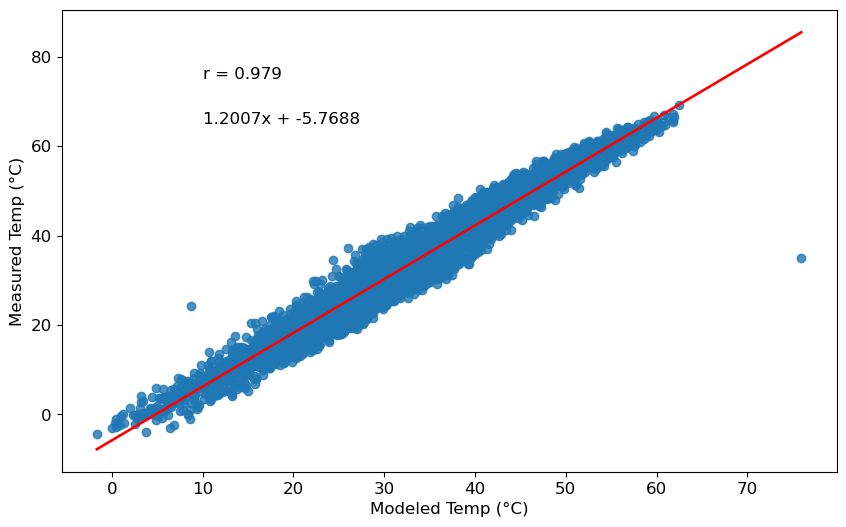

In [198]:
slope, intercept, r, p, std = scipy.stats.linregress(x = df.dropna()['Modeled Temp'], y = df.dropna()['Measured module temperature (°C)'])
sns.regplot(x = df['Modeled Temp'], y = df['Measured module temperature (°C)'], line_kws={'color':'red'})

plt.ylabel('Measured Temp (°C)')
plt.xlabel('Modeled Temp (°C)')
plt.text(10, 75, s = ("r = "+str(round(r,4))))
plt.text(10, 65, s = (str(round(slope,4))+'x + '+str(round(intercept,4))))

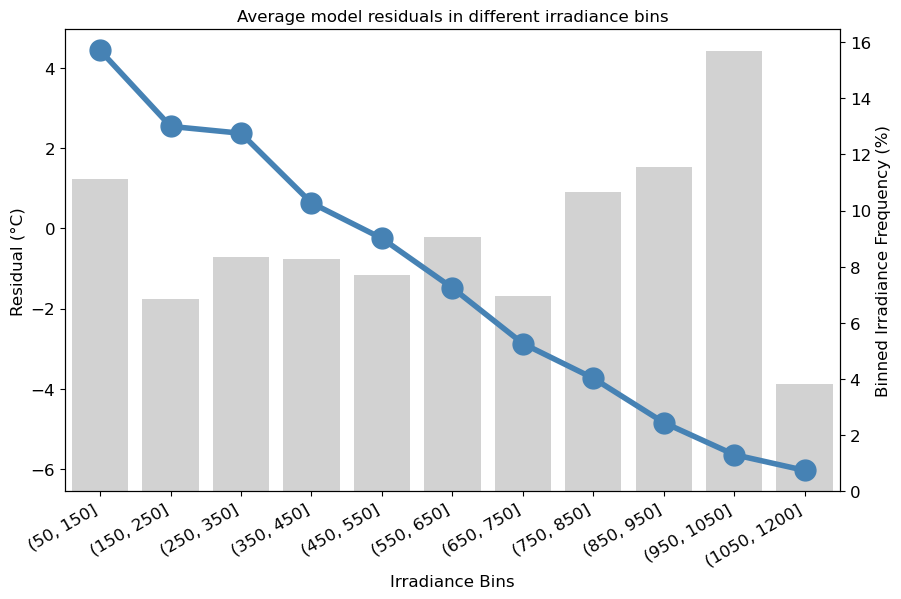

In [199]:
df['Irradiance Bins']=(pd.cut(x=df['Measured front POA irradiance (W/m2)'], bins=[50,150,250,350,450,550,650,750,850,950,1050,1200]))
binstr = ['(50, 150]','(150, 250]','(250, 350]','(350, 450]','(450, 550]','(550, 650]','(650, 750]','(750, 850]','(850, 950]','(950, 1050]','(1050, 1200]']

bins = df['Irradiance Bins'].value_counts()
bins = bins.to_frame()
bins.rename(columns = {'Irradiance Bins' : 'Frequency'}, inplace = True)
bins['Irradiance Bins'] = bins.index
bins['Freq Norm'] =( bins['Frequency']/bins['Frequency'].sum()) * 100
bins['Freq Norm'].sum()

fig, ax = plt.subplots()
x = binstr
y = df.groupby('Irradiance Bins').mean().sort_values('Irradiance Bins')['BE']
ax.plot(x, y, 'steelblue', marker='o', zorder=6.5, linewidth=4, markersize=15)
             
plt.xticks(rotation=30, ha='right')
ax.set_ylabel('Residual (°C)')
ax.set_xlabel('Irradiance Bins')

ax2 = ax.twinx()
ax2 = sns.barplot(x='Irradiance Bins', y='Freq Norm', data=bins, ci=None, color='grey', alpha=0.35, zorder=2.5)
ax2.set_ylabel('Binned Irradiance Frequency (%)')
plt.grid(False)
plt.xticks(rotation=30, ha='right')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

plt.title('Average model residuals in different irradiance bins')
plt.show()


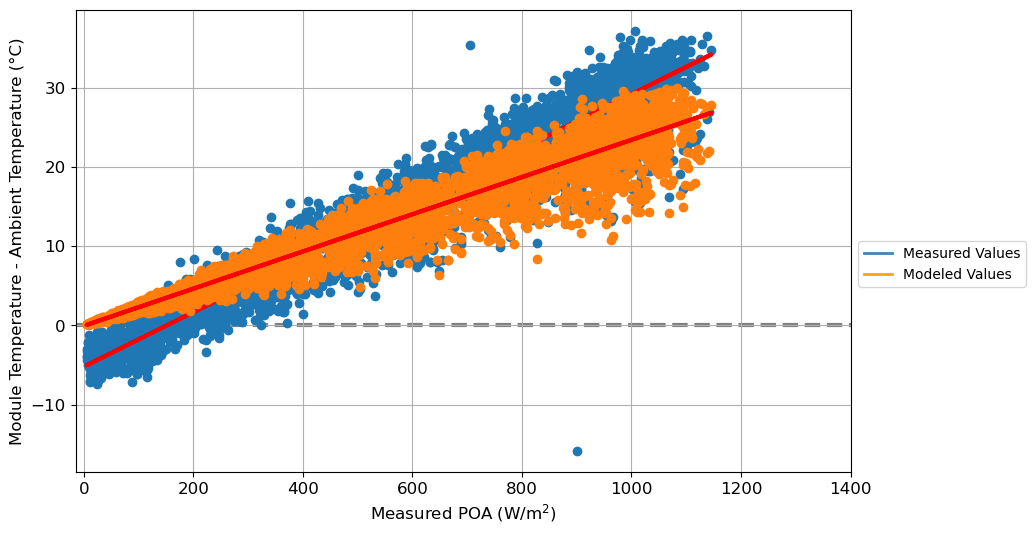

In [200]:
x = df['Measured front POA irradiance (W/m2)']
y = (df['Modeled Temp'] - df['Ambient Temp (°C) '])
y2 = (df['Measured module temperature (°C)'] - df['Ambient Temp (°C) '])
z = np.polyfit(x, y, 1)
z2 = np.polyfit(x, y2, 1)
p = np.poly1d(z)
p2 = np.poly1d(z2)
r = np.corrcoef(x,y)[0][1]
plt.scatter(x=df['Measured front POA irradiance (W/m2)'], y= (df['Measured module temperature (°C)'] - df['Ambient Temp (°C) ']),zorder=2)
plt.plot(x, p2(x), linewidth=3, color='red', zorder=2.5)
plt.scatter(x=df['Measured front POA irradiance (W/m2)'], y= (df['Modeled Temp'] - df['Ambient Temp (°C) ']), zorder=6.5)
plt.plot(x, p(x), linewidth=3, color='red',zorder=7)
plt.hlines(y=0, xmin=-15, xmax=1400, linewidth=3, color='grey',linestyles='--', zorder=0)
plt.xlim(-15,1400)
plt.ylabel('Module Temperature - Ambient Temperature (°C)')
plt.xlabel('Measured POA (W/m$^2$)')
plt.grid(True)

line_1 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label='Measured Values')
line_3 = Line2D([0], [0], color='orange', linewidth=2, linestyle='-',label='Modeled Values')
lines = [line_1,line_3]
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4],handles=lines)
# plt.axisbelow(True)

### Energy Yield Estimates
We can run two simulations, one using the temperature model and another using true module temperature data to see how much influence the errors of the model have on the overall energy yield

In [201]:
#using measured POA to estimate energy
df['DC Power - Meas Temp'] = module['String Length']*pvlib.pvsystem.pvwatts_dc(g_poa_effective=df['Measured front POA irradiance (W/m2)'], 
                                    temp_cell=pvlib.temperature.sapm_cell_from_module(df['Measured module temperature (°C)'], df['Measured front POA irradiance (W/m2)'], deltaT=3),
                                    pdc0=275, gamma_pdc=-0.0041)
#using modeled temp to estimate energy
df['DC Power - Model Temp'] = module['String Length']*pvlib.pvsystem.pvwatts_dc(g_poa_effective=df['Measured front POA irradiance (W/m2)'], 
                                    temp_cell=pvlib.temperature.sapm_cell_from_module(df['Modeled Temp'], df['Measured front POA irradiance (W/m2)'], deltaT=3),
                                    pdc0=275, gamma_pdc=-0.0041)
#find overall % diff for annual energy
print('With measured module temperature, predicted annual energy is', round(df['DC Power - Meas Temp'].sum()/1000,3),
      'kWh and with modeled module temperature, predicted annual energy is', round(df['DC Power - Model Temp'].sum()/1000,3), 'kWh')
print('The % difference in energy estimate when using measured vs modeled module temperature is ', 
      round(((df['DC Power - Model Temp'].sum()-df['DC Power - Meas Temp'].sum())/df['DC Power - Meas Temp'].sum())*100,3),'%')

With measured module temperature, predicted annual energy is 6739.188 kWh and with modeled module temperature, predicted annual energy is 6838.221 kWh
The % difference in energy estimate when using measured vs modeled module temperature is  1.47 %


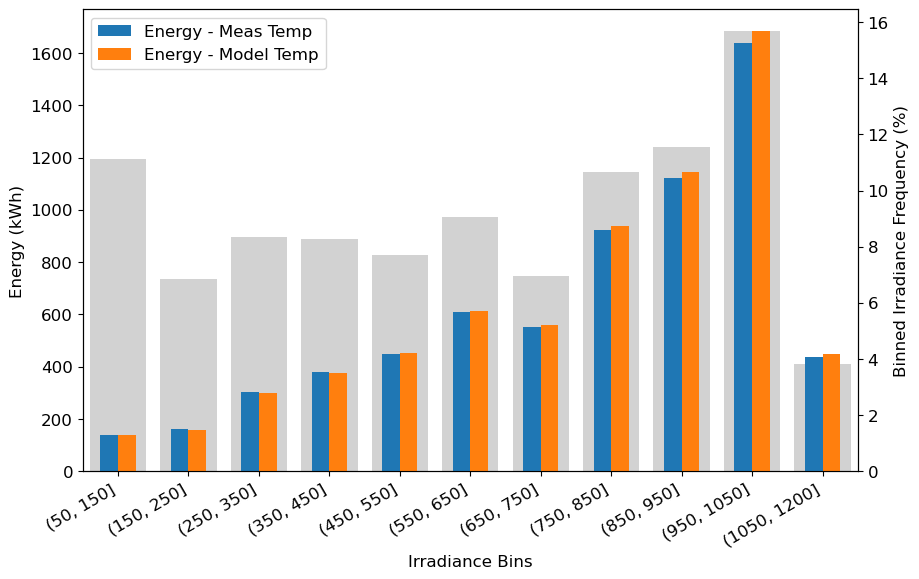

In [203]:
bins['Energy - Model Temp'] = df.groupby('Irradiance Bins').sum()['DC Power - Model Temp']/1000
bins['Energy - Meas Temp'] = df.groupby('Irradiance Bins').sum()['DC Power - Meas Temp']/1000
bins = bins.sort_values('Irradiance Bins')

ax = bins.plot(x="Irradiance Bins", y=["Energy - Meas Temp", "Energy - Model Temp"], kind="bar", rot=0)
             
plt.xticks(rotation=30, ha='right')
ax.set_ylabel('Energy (kWh)')
ax.set_xlabel('Irradiance Bins')

ax2 = ax.twinx()
ax2 = sns.barplot(x='Irradiance Bins', y='Freq Norm', data=bins, ci=None, color='grey', alpha=0.35, zorder=2.5)
ax2.set_ylabel('Binned Irradiance Frequency (%)')
plt.grid(False)
plt.xticks(rotation=30, ha='right')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)


# plt.title('NMBE (%) of model in different irradiance bins')
plt.show()


### Analysis II: Residual Analysis
#### • Residual Analysis - quantifies the degree that variables may affect model errors
## $V_{modeled} - V_{measured}$

### Residual Distribution
Residuals should be normally distributed, otherwise this indicates a consistent bias of over or under predicting \
To get a closer look at a majority of the residuals, the outer 1% are removed using z-score. The distribution should be centered about the mean, shown by the red line

Text(0.5, 0, 'Residuals (C)')

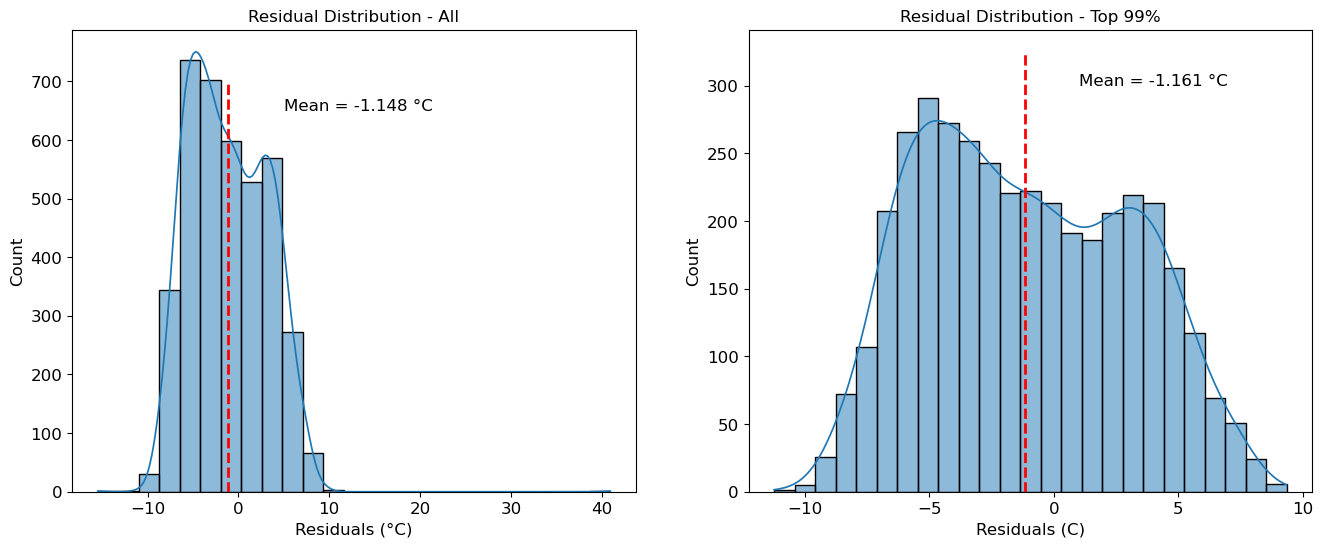

In [207]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

df['Residuals'] = df['Modeled Temp'] - df['Measured module temperature (°C)']
sns.histplot(df['Residuals'], kde=True, bins=25, ax=ax1)
ax1.vlines(x=df['Residuals'].mean(), ymin=0, ymax=700, linewidth=2, color='red',linestyles='--')
ax1.text(5,650,'Mean = '+str(round(df['Residuals'].mean(),3))+' °C' )
ax1.set_title('Residual Distribution - All')
ax1.set_xlabel('Residuals (°C)')

#Use z-score to eliminate the outer 1% of residuals
df['zscore'] = scipy.stats.zscore(df['Residuals'].dropna())
df['resid_trim'] = df['Residuals'][(df['zscore'] < 2.5) & (df['zscore'] > -2.5)]
sns.histplot(df['resid_trim'], kde=True, bins=25, ax=ax2)
ax2.vlines(x=df['resid_trim'].mean(), ymin=0, ymax=325, linewidth=2, color='red',linestyles='--')
ax2.text(1,300,'Mean = '+str(round(df['resid_trim'].mean(),3))+' °C' )
ax2.set_title('Residual Distribution - Top 99%')
ax2.set_xlabel('Residuals (C)')

Text(966.31045751634, 0.5, 'Model Residuals (°C)')

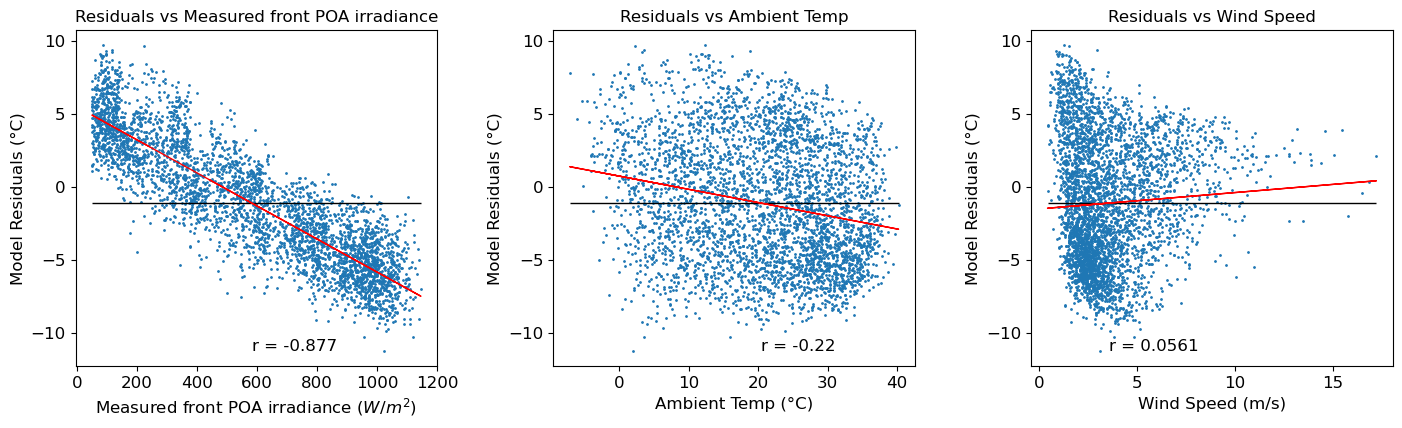

In [53]:
#plot residuals against common inputs into POA models

fig, axs = plt.subplots(1,3,figsize=(15,5))
fig.tight_layout(pad=4.0)
# y = df['Residuals']
# y_avg = df['Residuals'].mean()
# y_med = df['Residuals'].median()
df = df.dropna()
y = df['resid_trim']
y_avg =  df['resid_trim'].mean()
y_med =  df['resid_trim'].median()
x = df['Measured front POA irradiance (W/m2)']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[0].scatter(x, y, s=1)
axs[0].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[0].text(x = x.mean(), y=y.min(), s=( "r = "+str(round(r,4))))
axs[0].plot(x, p(x), linewidth=1, color='red')
axs[0].set_title('Residuals vs Measured front POA irradiance')
axs[0].set_xlabel('Measured front POA irradiance ($W/m^2$)')
axs[0].set_ylabel('Model Residuals (°C)')
x = df['Ambient Temp (°C) ']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[1].scatter(x, y, s=1)
axs[1].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[1].text(x = x.mean(), y=y.min(), s=( "r = "+str(round(r,4))))
axs[1].plot(x, p(x), linewidth=1, color='red')
axs[1].set_title('Residuals vs Ambient Temp')
axs[1].set_xlabel('Ambient Temp (°C)')
axs[1].set_ylabel('Model Residuals (°C)')
x = df['Wind Speed (m/s)']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[2].scatter(x, y, s=1)
axs[2].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[2].text(x = x.mean(), y=y.min(), s=( "r = "+str(round(r,4))))
axs[2].plot(x, p(x), linewidth=1, color='red')
axs[2].set_title('Residuals vs Wind Speed')
axs[2].set_xlabel('Wind Speed (m/s)')
axs[2].set_ylabel('Model Residuals (°C)')
# x = df['Zenith']
# z = np.polyfit(x, y, 1)
# p = np.poly1d(z)
# r = np.corrcoef(x,y)[0][1]
# axs[1, 0].scatter(x, y, s=1)
# axs[1, 0].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
# axs[1, 0].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))))
# axs[1, 0].plot(x, p(x), linewidth=1, color='red')
# axs[1, 0].set_title('Residuals vs Zenith')
# axs[1, 0].set_xlabel('Zenith')
# axs[1, 0].set_ylabel('Model Residuals ($W/m^2$)')
# x = df['Azimuth']
# z = np.polyfit(x, y, 1)
# p = np.poly1d(z)
# r = np.corrcoef(x,y)[0][1]
# axs[1, 1].scatter(x, y, s=1)
# axs[1, 1].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
# axs[1, 1].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))))
# axs[1, 1].plot(x, p(x), linewidth=1, color='red')
# axs[1, 1].set_title('Residuals vs Azimuth')
# axs[1, 1].set_xlabel('Azimuth')
# axs[1, 1].set_ylabel('Model Residuals ($W/m^2$)')
# x = df['Clearness Index']
# z = np.polyfit(x, y, 1)
# p = np.poly1d(z)
# r = np.corrcoef(x,y)[0][1]
# axs[1, 2].scatter(x, y, s=1)
# axs[1, 2].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
# axs[1, 2].text(x = x.median(), y=(y.min() + (0*y.min())), s=( "r = "+str(round(r,4))))
# axs[1, 2].plot(x, p(x), linewidth=1, color='red')
# axs[1, 2].set_title('Residuals vs Clearness Index')
# axs[1, 2].set_xlabel('Clearness Index')
# axs[1, 2].set_ylabel('Model Residuals ($W/m^2$)')



### Residuals by time of day
 Using AOI to describe time of day

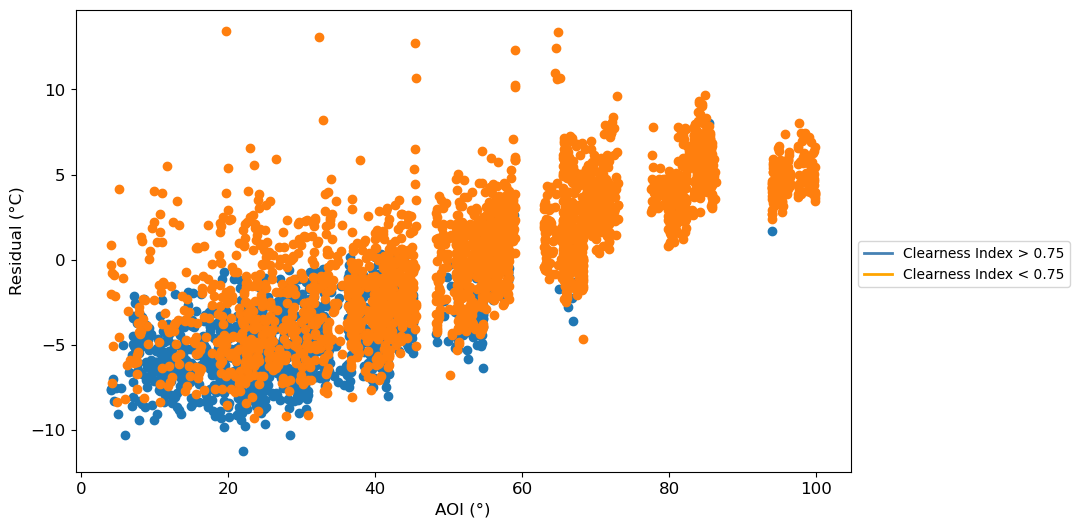

In [165]:
metric = 'Clearness Index' #other options could be clearness index, month, etc
bound = 0.75

df_h = df[df[metric] > bound]
df_l = df[df[metric] < bound]

plt.scatter(x=df_h['AOI'], y=df_h['resid_trim'])
plt.scatter(x=df_l['AOI'], y=df_l['resid_trim'])

plt.ylabel('Residual (°C)')
plt.xlabel('AOI (°)')

line_1 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label=(metric+' > '+str(bound)))
line_3 = Line2D([0], [0], color='orange', linewidth=2, linestyle='-',label=(metric+' < '+str(bound)))
lines = [line_1,line_3]
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4],handles=lines)

### Residuals by month
Grouping the residuals by month is one way to check if the model has any extreme behavior in specific seasons of the year \
This is done below with a boxplot which shows the spread of the data within the months and a jointplot which can show this and the distribution of the data across the months as well

Text(463.154761904762, 0.5, 'Residuals (°C)')

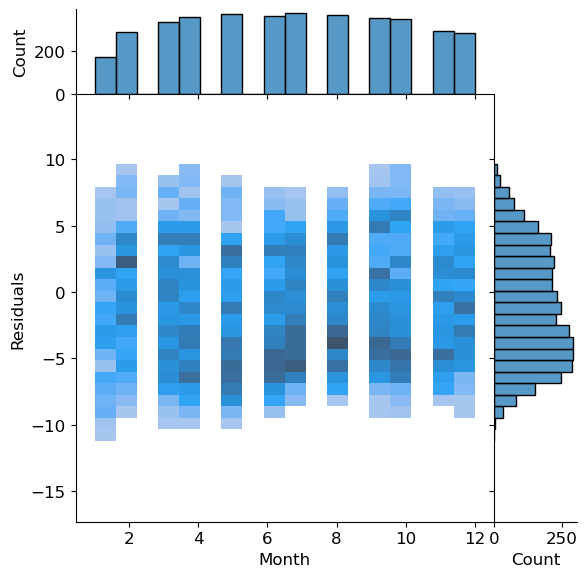

In [115]:
sns.jointplot(data=df, x='Month', y='Residuals', kind='hist', space=0, marginal_ticks=True)
plt.ylim((-1*abs((df['Residuals'].describe()['25%']) - abs(3*df['Residuals'].describe()['std']))),abs((df['Residuals'].describe()['75%']) + abs(3*df['Residuals'].describe()['std'])))
plt.ylabel('Residuals (°C)')

Text(0, 0.5, 'Residuals (°C)')

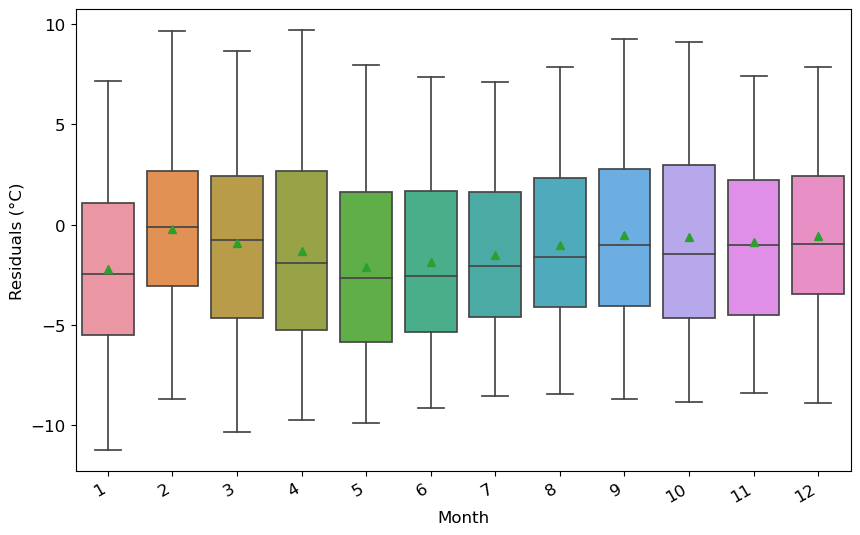

In [114]:
sns.boxplot(data=df, x='Month', y='Residuals', showfliers=False, showmeans=True)
plt.xticks(rotation=30, ha='right')
plt.ylabel('Residuals (°C)')

### Analemma Plots
These are another way to check seasonality of a model and can also show how the model performs at specific times of day

Text(0.5, 0, 'Solar Azimuth')

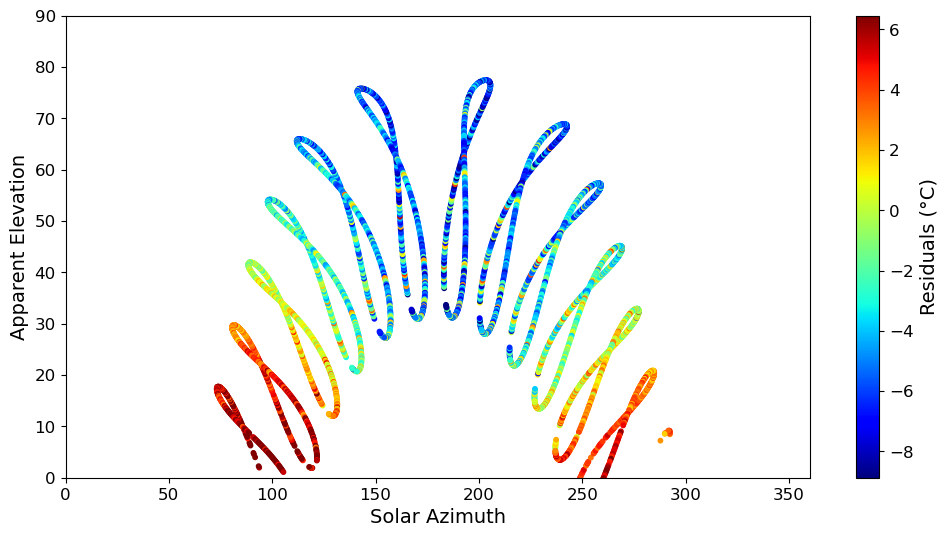

In [113]:
#analemma plots show the residuals at different times of the day/year
plt.figure(figsize=(12,6))
plt.scatter(x=df['Azimuth'], y=df['Sol Elev'], c=df['resid_trim'], cmap='jet', s=10)
clb = plt.colorbar()
clb.ax.set_ylabel('Residuals (°C)',fontsize =14)
plt.clim((df['resid_trim'].describe()['25%'] - df['resid_trim'].describe()['std']),(df['resid_trim'].describe()['75%'] + df['resid_trim'].describe()['std']))
plt.xlim(0,360)
plt.ylim(0,90)
plt.ylabel('Apparent Elevation', fontsize=14 )
plt.xlabel('Solar Azimuth',fontsize =14)


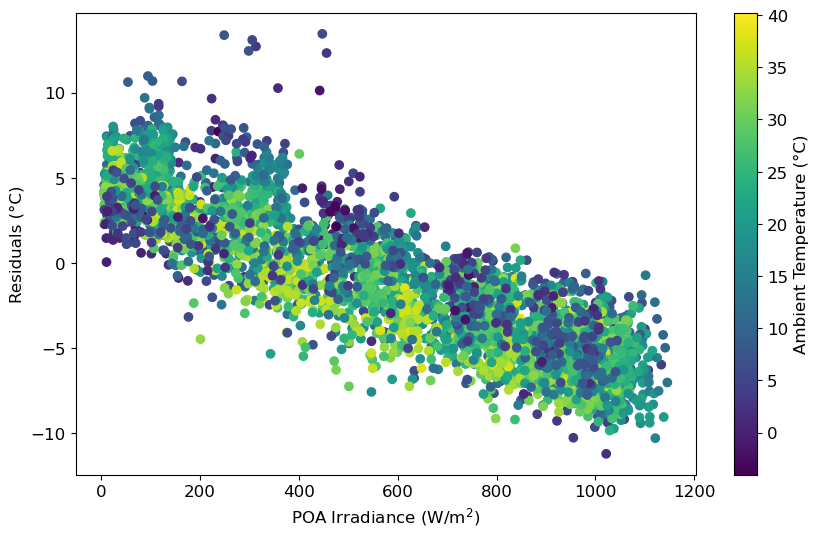

In [161]:
plt.scatter(df['Measured front POA irradiance (W/m2)'], df['resid_trim'], c=df['Ambient Temp (°C) '])
plt.ylabel('Residuals (°C)')
plt.xlabel('POA Irradiance (W/m$^2$)')
plt.colorbar(label='Ambient Temperature (°C)')

### Empirical Cumulative Distribution Plot (ECDF)
This plot shows the cumulative distribution of the residuals with the median as the dashed line and the mean as the solid line

Text(5.182220670102019, 0.2, 'P90 = 4.711 °C')

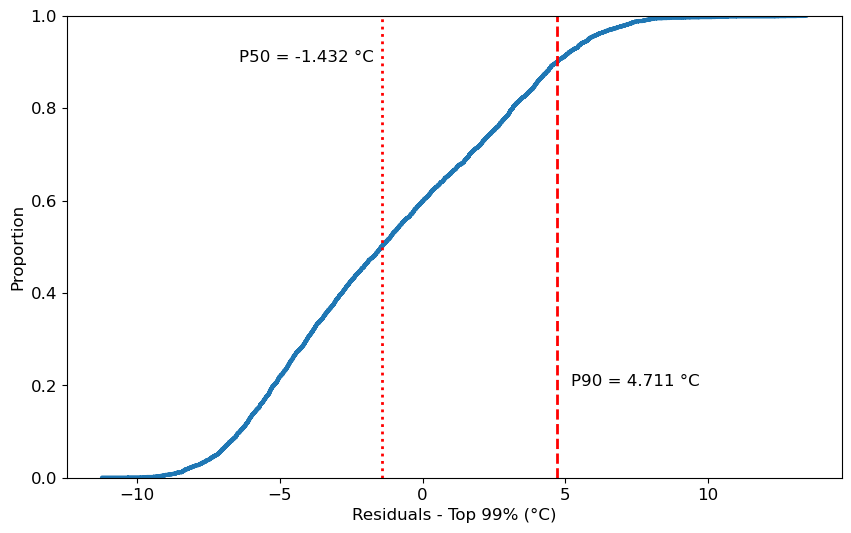

In [145]:
#plot empirical cumulative distribution functions
sns.ecdfplot(data=df, x='resid_trim', linewidth=3)
plt.xlabel('Residuals - Top 99% (°C)')
plt.vlines(x=np.percentile(df['resid_trim'].dropna(), 50), ymin=0, ymax=1, linewidth=2, color='red',linestyles='dotted')
plt.text((np.percentile(df['resid_trim'].dropna(), 50) - (-3.5*np.percentile(df['resid_trim'].dropna(), 50))), 0.9, 'P50 = '+str(round(np.percentile(df['resid_trim'].dropna(), 50),3))+' °C')
plt.vlines(x=np.percentile(df['resid_trim'].dropna(), 90), ymin=0, ymax=1, linewidth=2, color='red',linestyles='--')
plt.text((np.percentile(df['resid_trim'].dropna(), 90) + (0.1*np.percentile(df['resid_trim'].dropna(), 90))), 0.2, 'P90 = '+str(round(np.percentile(df['resid_trim'].dropna(), 90),3))+' °C')

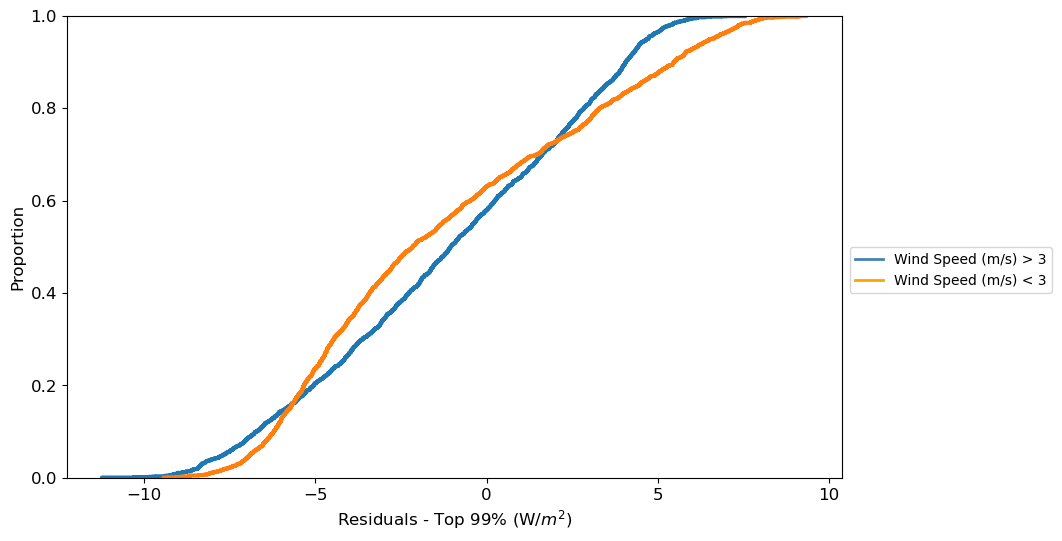

In [208]:
metric = 'Wind Speed (m/s)' #other options could be clearness index, month, etc
bound = 3

df_h = df[df[metric] > bound]
df_l = df[df[metric] < bound]

sns.ecdfplot(data=df_h, x='resid_trim', linewidth=3)
sns.ecdfplot(data=df_l, x='resid_trim', linewidth=3)

plt.xlabel('Residuals - Top 99% (W/$m^2$)')

line_1 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label=(metric+' > '+str(bound)))
line_3 = Line2D([0], [0], color='orange', linewidth=2, linestyle='-',label=(metric+' < '+str(bound)))
lines = [line_1,line_3]
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4],handles=lines)

### Analysis III: Comparison to Baseline Models
##### Comparing the model to other well-known baseline models can provide information about how the model is performing relative to accepted models


In [189]:
#Either run a model here or import the results. They should be the same length as the original df and use middle-of-hour timestamps for calculations
tmp = (pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer'])
df['Baseline Model Temp'] = pvlib.temperature.sapm_module(poa_global=df['Measured front POA irradiance (W/m2)'], temp_air=df['Ambient Temp (°C) '], wind_speed=df['Wind Speed (m/s)'],
                           a=tmp['a'], b=tmp['b'])
df['Baseline Residuals'] = df['Baseline Model Temp'] - df['Measured module temperature (°C)']

In [190]:
#using modeled temp to estimate energy
df['DC Power - Baseline Model Temp'] = module['String Length']*pvlib.pvsystem.pvwatts_dc(g_poa_effective=df['Measured front POA irradiance (W/m2)'], 
                                    temp_cell=pvlib.temperature.sapm_cell_from_module(df['Baseline Model Temp'], df['Measured front POA irradiance (W/m2)'], deltaT=3),
                                    pdc0=275, gamma_pdc=-0.0041)
#find overall % diff for annual energy
print('With the initial model module temperature, predicted annual energy is', round(df['DC Power - Model Temp'].sum()/1000,3),
      'kWh and with modeled module temperature, predicted annual energy is', round(df['DC Power - Baseline Model Temp'].sum()/1000,3), 'kWh')
print('The % difference in energy estimate when using measured vs modeled module temperature is ', 
      round(((df['DC Power - Baseline Model Temp'].sum()-df['DC Power - Model Temp'].sum())/df['DC Power - Model Temp'].sum())*100,3),'%')

With the initial model module temperature, predicted annual energy is 7023.896 kWh and with modeled module temperature, predicted annual energy is 7051.287 kWh
The % difference in energy estimate when using measured vs modeled module temperature is  0.39 %


Text(0, 0.5, 'Residual (°C)')

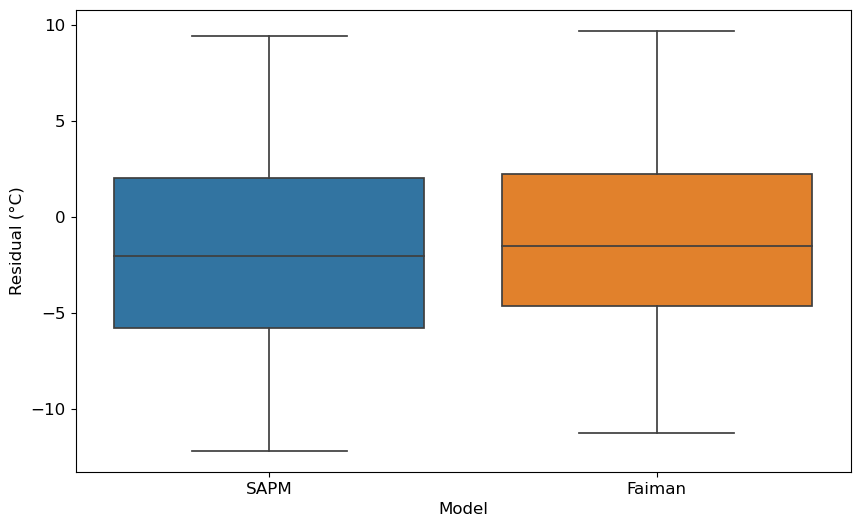

In [119]:
resid = []
temp_b = ((df['Baseline Model Temp'] - df['Measured module temperature (°C)'])).to_frame()
temp_b.rename(columns = {0 : 'Residual'}, inplace = True)
temp_b['Model'] = 'SAPM'
resid.append(temp_b)
test =  ((df['Modeled Temp'] - df['Measured module temperature (°C)'])).to_frame()
test.rename(columns = {0 : 'Residual'}, inplace = True)
test['Model'] = model_name
resid.append(test)
resid_df = pd.concat(resid, ignore_index=True)
sns.boxplot(x='Model', y='Residual', data=resid_df)
plt.ylabel('Residual (°C)')

print errors values on plots

In [ ]:
energy yield impact